In [ ]:
import kagglehub


path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

100%|██████████| 839M/839M [00:43<00:00, 20.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1


Using device: cuda:0
GPU Name: Tesla T4
Total GPU Memory: 14.74 GB
Total .mat files found: 3064
Train files: 2451 Validation files: 613


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B


--- Training Teacher Model ---
Epoch [1/25] Train Loss: 0.3492 | Val Loss: 0.2566 | Dice: 0.0019
Epoch [2/25] Train Loss: 0.2093 | Val Loss: 0.1647 | Dice: 0.0019
Epoch [3/25] Train Loss: 0.1457 | Val Loss: 0.1220 | Dice: 0.0019
Epoch [4/25] Train Loss: 0.1108 | Val Loss: 0.0989 | Dice: 0.0019
Epoch [5/25] Train Loss: 0.0892 | Val Loss: 0.0829 | Dice: 0.0019
Epoch [6/25] Train Loss: 0.0745 | Val Loss: 0.0698 | Dice: 0.1238
Epoch [7/25] Train Loss: 0.0634 | Val Loss: 0.0630 | Dice: 0.3467
Epoch [8/25] Train Loss: 0.0546 | Val Loss: 0.0554 | Dice: 0.3145
Epoch [9/25] Train Loss: 0.0485 | Val Loss: 0.0581 | Dice: 0.3767
Epoch [10/25] Train Loss: 0.0437 | Val Loss: 0.0472 | Dice: 0.2879
Epoch [11/25] Train Loss: 0.0399 | Val Loss: 0.0428 | Dice: 0.4719
Epoch [12/25] Train Loss: 0.0357 | Val Loss: 0.0418 | Dice: 0.3244
Epoch [13/25] Train Loss: 0.0331 | Val Loss: 0.0441 | Dice: 0.4518
Epoch [14/25] Train Loss: 0.0307 | Val Loss: 0.0404 | Dice: 0.3966
Epoch [15/25] Train Loss: 0.0289 | Val 

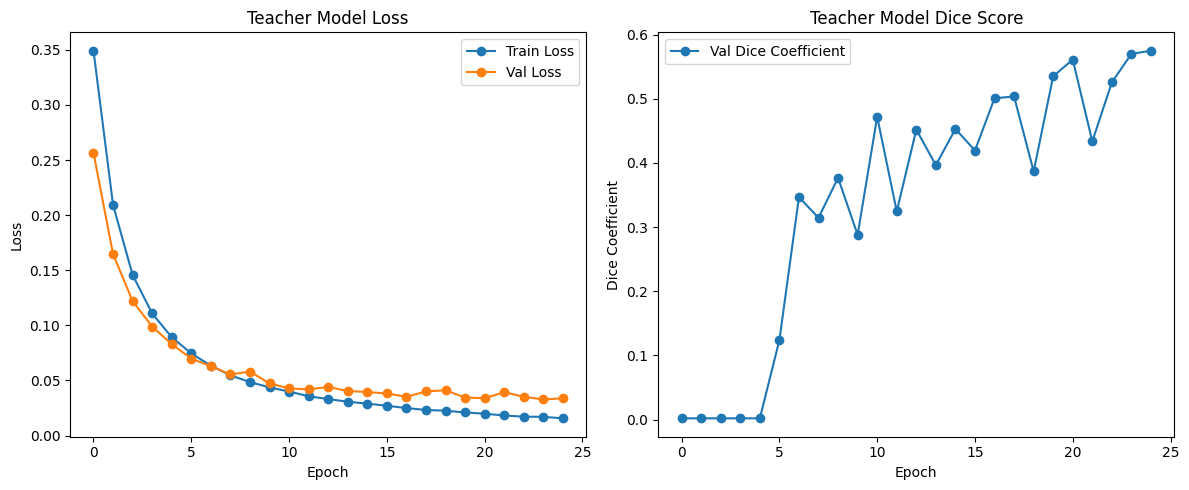

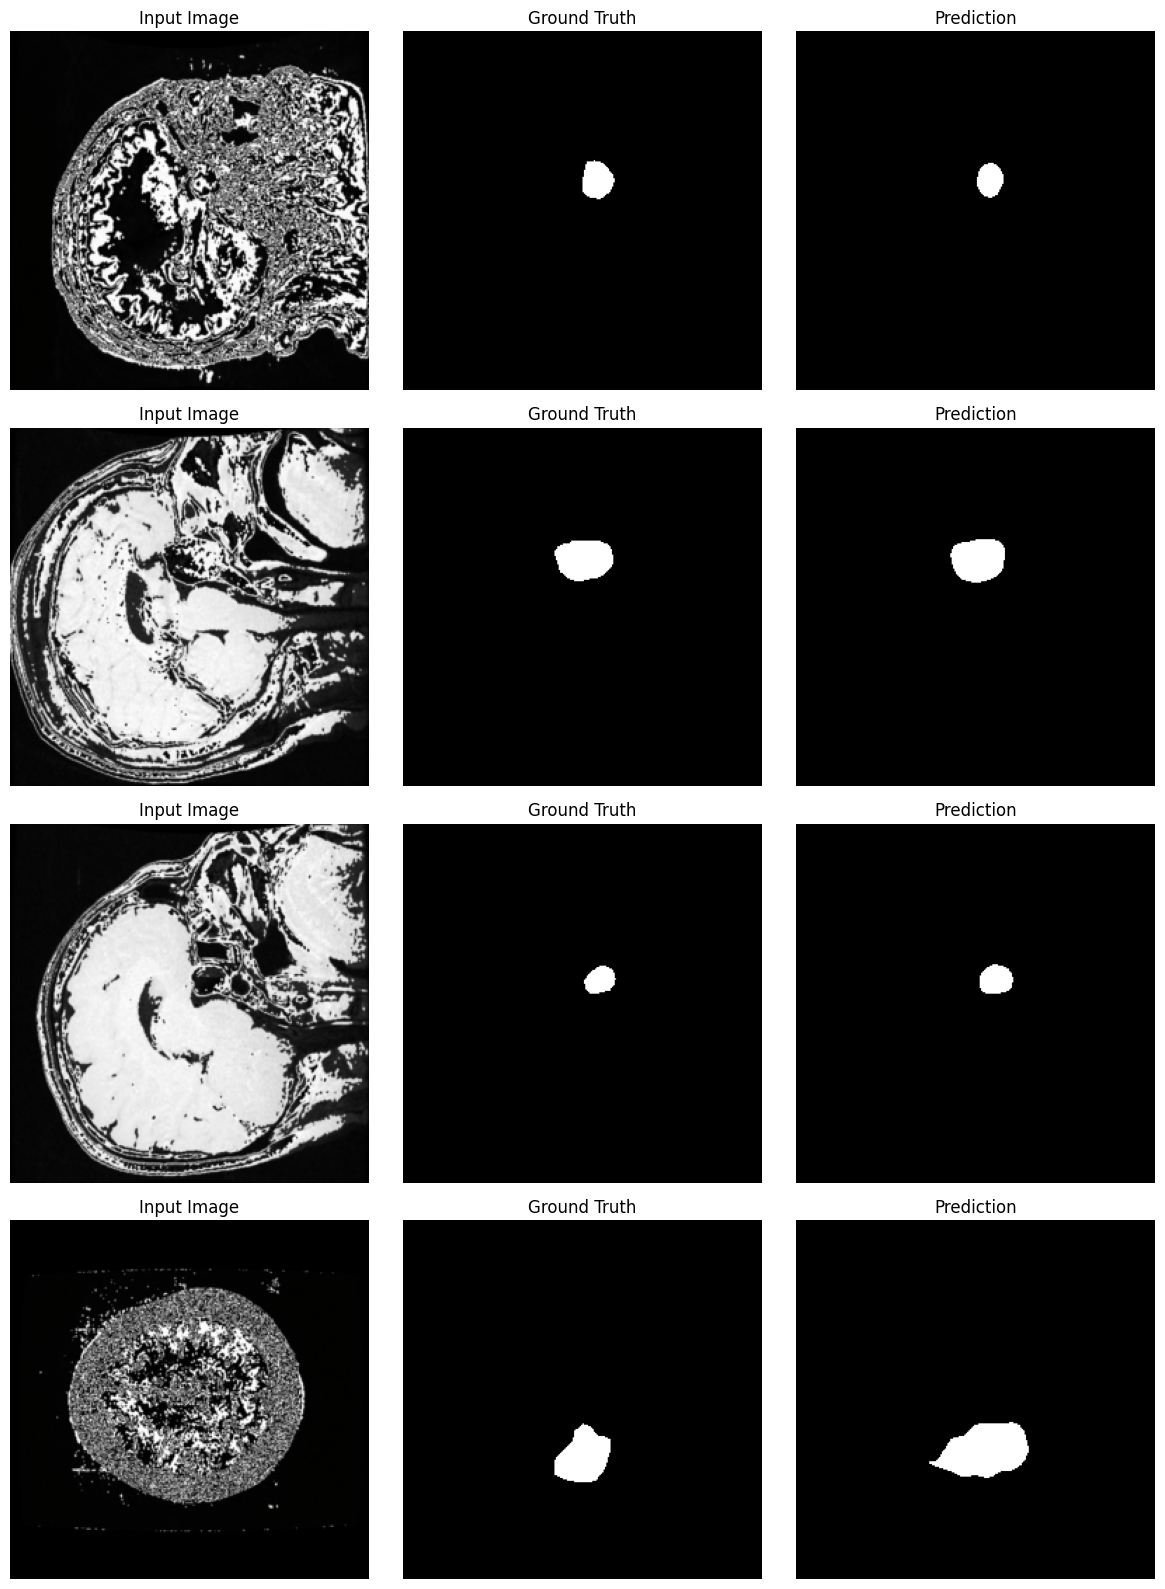

In [ ]:
import os
import glob
import numpy as np
import h5py
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
from torchvision import models

# --------------------------
# Device Setup
# --------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    gpu_props = torch.cuda.get_device_properties(0)
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Total GPU Memory: {:.2f} GB".format(gpu_props.total_memory / (1024**3)))

# --------------------------
# Utility Function: Load MATLAB file
# --------------------------
def load_matlab_file(file_path):
    with h5py.File(file_path, 'r') as f:
        if "cjdata" in f:
            group = f["cjdata"]
            data = {key: group[key][()] for key in group.keys()}
            return data
        else:
            return {k: f[k][()] for k in f.keys()}

# --------------------------
# Data Augmentation and Preprocessing for Segmentation
# --------------------------
def seg_transform(image, mask, is_train=True, target_size=(256,256)):
    # Resize image and mask (mask uses nearest interpolation)
    image = TF.resize(image, target_size)
    mask = TF.resize(mask, target_size, interpolation=Image.NEAREST)
    if is_train:
        # Apply random horizontal flip
        if np.random.rand() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
    # For image: convert to tensor and normalize
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
    # For mask: convert to numpy array and ensure binary (0,1)
    mask = np.array(mask, dtype=np.uint8)
    if mask.max() > 1:
        mask = mask / 255.0
    mask = torch.from_numpy(mask).float().unsqueeze(0)  # add channel dim
    return image, mask

# --------------------------
# Custom Dataset for Segmentation
# --------------------------
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, file_list, is_train=True):
        self.file_list = file_list
        self.is_train = is_train

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        data = load_matlab_file(file_path)

        # Load image
        if "image" not in data:
            raise KeyError(f"'image' not found in file: {file_path}")
        image = data["image"]
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        if image.dtype != np.uint8:
            image = (255 * (image - np.min(image)) / (np.ptp(image) + 1e-8)).astype(np.uint8)
        image = Image.fromarray(image)

        # Load mask: use tumorMask if available, otherwise generate from tumorBorder.
        if "tumorMask" in data and data["tumorMask"] is not None:
            mask = data["tumorMask"]
            if mask.ndim == 2:
                mask = Image.fromarray((mask * 255).astype(np.uint8))
            else:
                mask = Image.fromarray(mask)
        elif "tumorBorder" in data and data["tumorBorder"] is not None:
            mask = Image.new("L", image.size, 0)
            draw = ImageDraw.Draw(mask)
            pts = list(np.squeeze(data["tumorBorder"]))
            pts = [(pts[i], pts[i+1]) for i in range(0, len(pts), 2)]
            draw.polygon(pts, outline=1, fill=1)
            mask = mask.convert("L")
        else:
            raise ValueError("No tumorMask or tumorBorder found in file: " + file_path)

        image, mask = seg_transform(image, mask, is_train=self.is_train, target_size=(256,256))
        return image, mask

# --------------------------
# Prepare Dataset and DataLoaders
# --------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1"
all_files = glob.glob(os.path.join(dataset_dir, '**', '*.mat'), recursive=True)
all_files = [f for f in all_files if "cvind" not in os.path.basename(f).lower()]
print("Total .mat files found:", len(all_files))

np.random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]
print("Train files:", len(train_files), "Validation files:", len(val_files))

train_dataset = BrainTumorSegmentationDataset(train_files, is_train=True)
val_dataset = BrainTumorSegmentationDataset(val_files, is_train=False)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --------------------------
# U-Net Building Blocks for the Teacher Model
# --------------------------
class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# --------------------------
# Hybrid Teacher Model: U-Net + ViT Fusion
# --------------------------
class HybridTeacherModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, bilinear=True):
        super(HybridTeacherModel, self).__init__()
        # U-Net Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(512, 1024)

        # ViT branch: use a pretrained ViT with its head removed.
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()
        vit_feature_dim = self.vit.hidden_dim  # typically 768
        self.vit_proj = nn.Linear(vit_feature_dim, 1024)

        # Decoder with skip connections
        self.up4 = Up(1024+512, 512, bilinear)
        self.up3 = Up(512+256, 256, bilinear)
        self.up2 = Up(256+128, 128, bilinear)
        self.up1 = Up(128+64, 64, bilinear)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x, return_features=False):
        # Encoder
        x1 = self.enc1(x)                # [B, 64, H, W]
        x2 = self.enc2(self.pool1(x1))     # [B, 128, H/2, W/2]
        x3 = self.enc3(self.pool2(x2))     # [B, 256, H/4, W/4]
        x4 = self.enc4(self.pool3(x3))     # [B, 512, H/8, W/8]
        x_bridge = self.bridge(self.pool4(x4))  # [B, 1024, H/16, W/16]

        # ViT branch: resize input to 224x224 as expected by ViT.
        vit_input = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=True)
        vit_feat = self.vit(vit_input)    # shape: (B, hidden_dim)
        vit_feat = self.vit_proj(vit_feat)  # shape: (B, 1024)
        vit_feat = vit_feat.unsqueeze(-1).unsqueeze(-1)  # (B, 1024, 1, 1)
        vit_feat = vit_feat.expand_as(x_bridge)

        # Fuse ViT features with U-Net bridge features
        x_bridge = x_bridge + vit_feat

        # Decoder with skip connections
        d4 = self.up4(x_bridge, x4)  # [B, 512, H/8, W/8]
        d3 = self.up3(d4, x3)        # [B, 256, H/4, W/4]
        d2 = self.up2(d3, x2)        # [B, 128, H/2, W/2]
        d1 = self.up1(d2, x1)        # [B, 64, H, W]
        logits = self.outc(d1)       # [B, num_classes, H, W]

        if return_features:
            features = {"d4": d4, "d3": d3, "d2": d2, "d1": d1, "logits": logits}
            return logits, features
        else:
            return logits

# --------------------------
# Dice Coefficient Metric for Evaluation
# --------------------------
def dice_coeff(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth)
    return dice.mean()

# --------------------------
# Teacher Model Training Loop
# --------------------------
teacher_model = HybridTeacherModel(in_channels=3, num_classes=1).to(device)
criterion_seg = nn.BCEWithLogitsLoss()
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=1e-4)

num_epochs_teacher = 25
train_losses = []
val_losses = []
val_dices = []

print("\n--- Training Teacher Model ---")
for epoch in range(num_epochs_teacher):
    teacher_model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer_teacher.zero_grad()
        outputs = teacher_model(images)
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_teacher.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    teacher_model.eval()
    running_loss_val = 0.0
    dice_score = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = teacher_model(images)
            loss = criterion_seg(outputs, masks)
            running_loss_val += loss.item() * images.size(0)
            dice_score += dice_coeff(outputs, masks).item() * images.size(0)
    val_loss = running_loss_val / len(val_loader.dataset)
    dice_score = dice_score / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_dices.append(dice_score)

    print(f"Epoch [{epoch+1}/{num_epochs_teacher}] Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Dice: {dice_score:.4f}")

# Save the trained teacher model
teacher_model_path = "teacher_hybrid_unet_vit_seg.pth"
torch.save(teacher_model.state_dict(), teacher_model_path)
print(f"Teacher model saved to {teacher_model_path}")

# --------------------------
# Visualization: Training Curves
# --------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Teacher Model Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_dices, label="Val Dice Coefficient", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Teacher Model Dice Score")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Visualization: Sample Predictions from Teacher Model
# --------------------------
teacher_model.eval()
sample_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
images, masks = next(iter(sample_loader))
images = images.to(device)
with torch.no_grad():
    outputs = teacher_model(images)
preds = torch.sigmoid(outputs)
preds = (preds > 0.5).float()
images = images.cpu()

# Function to undo normalization for visualization
def inv_normalize(img_tensor):
    inv_trans = TF.normalize(img_tensor, [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             [1/0.229, 1/0.224, 1/0.225])
    return torch.clamp(inv_trans, 0, 1)

fig, axes = plt.subplots(4, 3, figsize=(12,16))
for i in range(4):
    img = inv_normalize(images[i])
    mask = masks[i].squeeze(0)
    pred = preds[i].squeeze(0)
    axes[i,0].imshow(img.permute(1,2,0))
    axes[i,0].set_title("Input Image")
    axes[i,0].axis("off")
    axes[i,1].imshow(mask, cmap="gray")
    axes[i,1].set_title("Ground Truth")
    axes[i,1].axis("off")
    axes[i,2].imshow(pred.cpu().squeeze(0), cmap="gray")
    axes[i,2].set_title("Prediction")
    axes[i,2].axis("off")
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0
Train files: 2451 Validation files: 613

--- Training Student Model with Knowledge Distillation ---
Epoch [1/30] Total Loss: 34.7428 | Val Loss: 0.4366 | Dice: 0.0018
Epoch [2/30] Total Loss: 31.1257 | Val Loss: 0.3280 | Dice: 0.0021
Epoch [3/30] Total Loss: 27.8727 | Val Loss: 0.2904 | Dice: 0.0029
Epoch [4/30] Total Loss: 24.1909 | Val Loss: 0.1792 | Dice: 0.0016
Epoch [5/30] Total Loss: 20.3959 | Val Loss: 0.1138 | Dice: 0.0016
Epoch [6/30] Total Loss: 16.9181 | Val Loss: 0.0867 | Dice: 0.0017
Epoch [7/30] Total Loss: 13.6866 | Val Loss: 0.0653 | Dice: 0.0017
Epoch [8/30] Total Loss: 10.7125 | Val Loss: 0.0579 | Dice: 0.0017
Epoch [9/30] Total Loss: 8.1928 | Val Loss: 0.0468 | Dice: 0.0017
Epoch [10/30] Total Loss: 6.0343 | Val Loss: 0.0448 | Dice: 0.0017
Epoch [11/30] Total Loss: 4.3650 | Val Loss: 0.0463 | Dice: 0.2526
Epoch [12/30] 

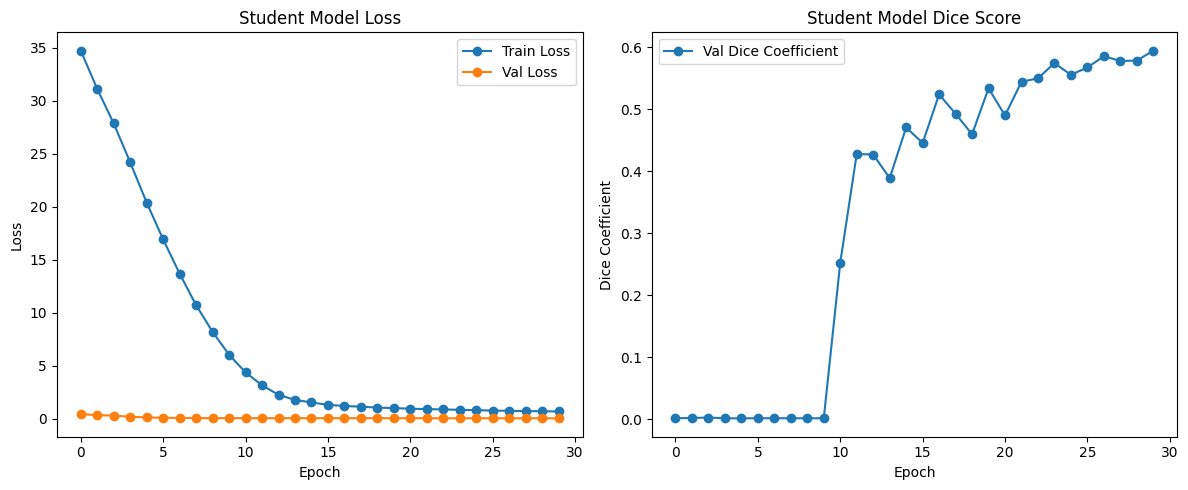

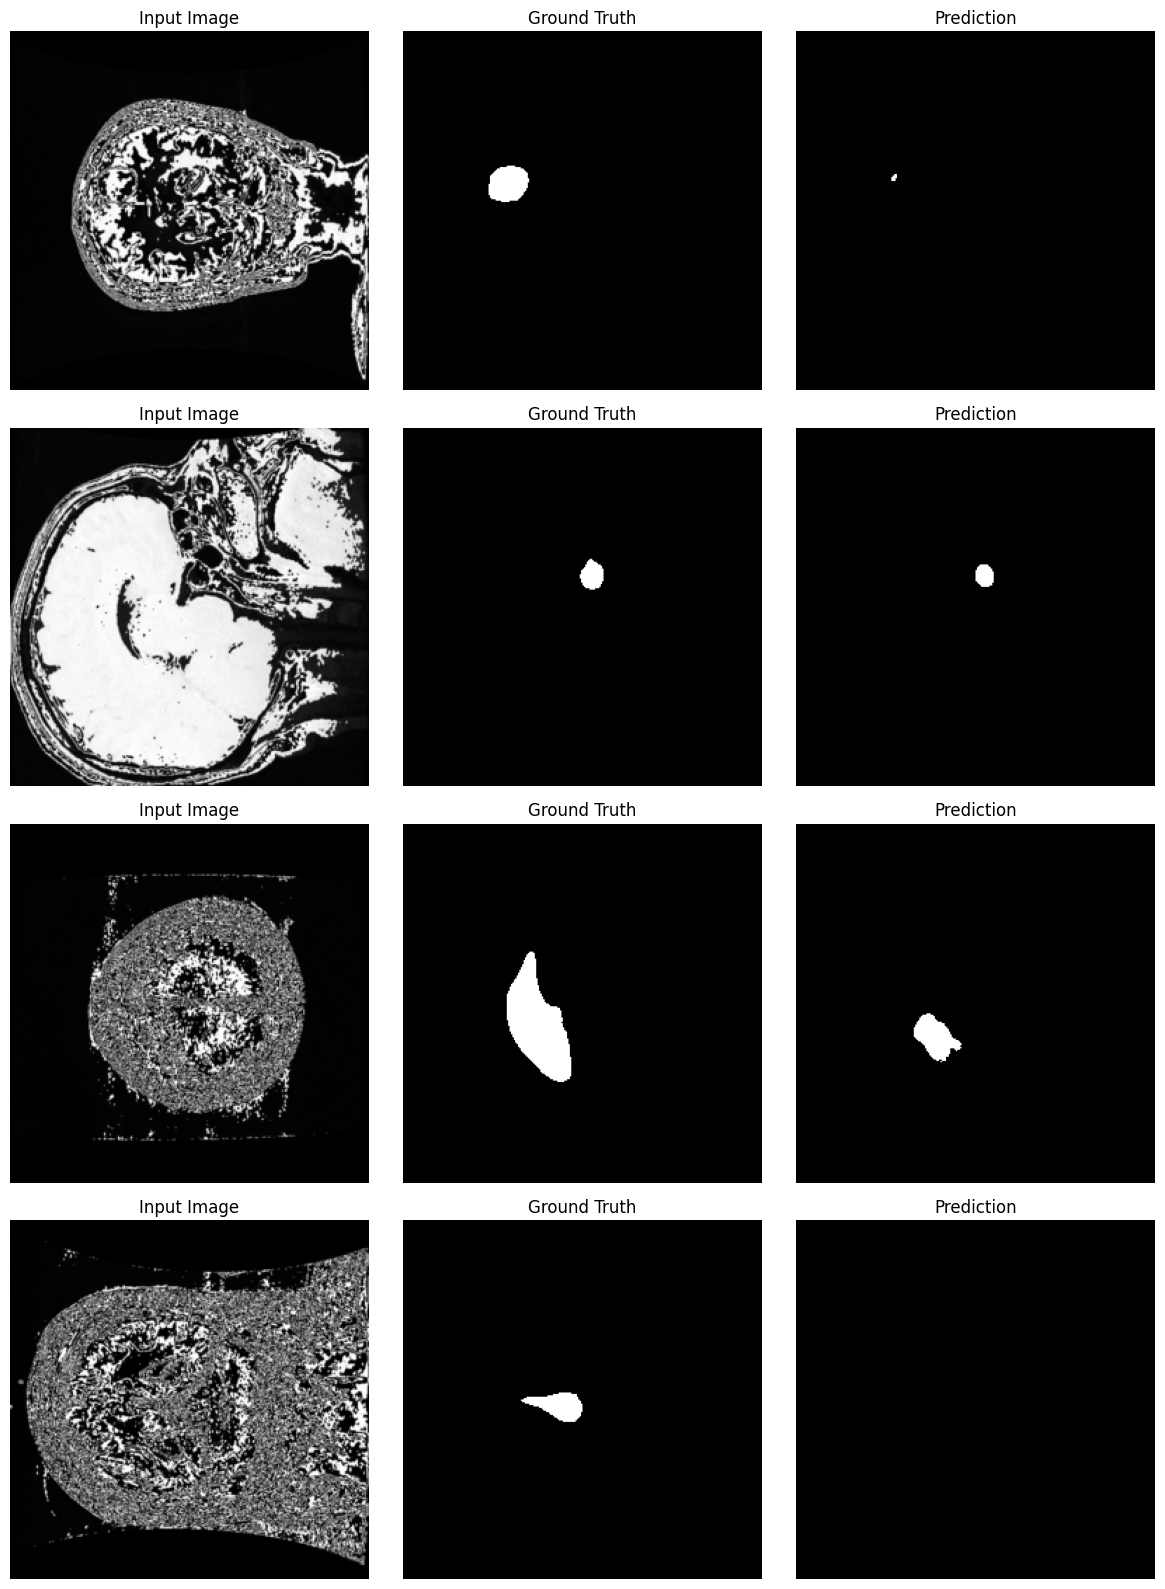

In [ ]:
import os
import glob
import numpy as np
import h5py
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms.functional as TF
from torchvision import models

# --------------------------
# Mount Google Drive
# --------------------------
from google.colab import drive
drive.mount('/content/drive')

# --------------------------
# Device Setup
# --------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# Utility Function: Load MATLAB file
# --------------------------
def load_matlab_file(file_path):
    with h5py.File(file_path, 'r') as f:
        if "cjdata" in f:
            group = f["cjdata"]
            data = {key: group[key][()] for key in group.keys()}
            return data
        else:
            return {k: f[k][()] for k in f.keys()}

# --------------------------
# Data Augmentation and Preprocessing for Segmentation
# --------------------------
def seg_transform(image, mask, is_train=True, target_size=(256,256)):
    # Resize image and mask (mask uses nearest interpolation)
    image = TF.resize(image, target_size)
    mask = TF.resize(mask, target_size, interpolation=Image.NEAREST)
    if is_train:
        # Apply random horizontal flip
        if np.random.rand() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
    # For image: convert to tensor and normalize
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])
    # For mask: convert to numpy array and ensure binary (0,1)
    mask = np.array(mask, dtype=np.uint8)
    if mask.max() > 1:
        mask = mask / 255.0
    mask = torch.from_numpy(mask).float().unsqueeze(0)  # add channel dim
    return image, mask

# --------------------------
# Custom Dataset for Segmentation
# --------------------------
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, file_list, is_train=True):
        self.file_list = file_list
        self.is_train = is_train

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        data = load_matlab_file(file_path)

        # Load image
        if "image" not in data:
            raise KeyError(f"'image' not found in file: {file_path}")
        image = data["image"]
        if image.ndim == 2:
            image = np.stack([image] * 3, axis=-1)
        if image.dtype != np.uint8:
            image = (255 * (image - np.min(image)) / (np.ptp(image)+1e-8)).astype(np.uint8)
        image = Image.fromarray(image)

        # Load mask: use tumorMask if available; otherwise generate from tumorBorder.
        if "tumorMask" in data and data["tumorMask"] is not None:
            mask = data["tumorMask"]
            if mask.ndim == 2:
                mask = Image.fromarray((mask*255).astype(np.uint8))
            else:
                mask = Image.fromarray(mask)
        elif "tumorBorder" in data and data["tumorBorder"] is not None:
            mask = Image.new("L", image.size, 0)
            draw = ImageDraw.Draw(mask)
            pts = list(np.squeeze(data["tumorBorder"]))
            pts = [(pts[i], pts[i+1]) for i in range(0, len(pts), 2)]
            draw.polygon(pts, outline=1, fill=1)
            mask = mask.convert("L")
        else:
            raise ValueError("No tumorMask or tumorBorder found in file: " + file_path)

        image, mask = seg_transform(image, mask, is_train=self.is_train, target_size=(256,256))
        return image, mask

# --------------------------
# U-Net Building Blocks
# --------------------------
class DoubleConv(nn.Module):
    """(Conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
           nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True),
           nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# --------------------------
# Dice Coefficient Metric for Evaluation
# --------------------------
def dice_coeff(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth)
    return dice.mean()

# --------------------------
# Inverse Normalization (for Visualization)
# --------------------------
def inv_normalize(img_tensor):
    inv_trans = TF.normalize(img_tensor, [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             [1/0.229, 1/0.224, 1/0.225])
    return torch.clamp(inv_trans, 0, 1)

# --------------------------
# Hybrid Teacher Model: U-Net + ViT Fusion
# --------------------------
class HybridTeacherModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, bilinear=True):
        super(HybridTeacherModel, self).__init__()
        # U-Net Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(512, 1024)

        # ViT branch: use a pretrained ViT with its head removed.
        self.vit = models.vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()
        vit_feature_dim = self.vit.hidden_dim  # typically 768
        self.vit_proj = nn.Linear(vit_feature_dim, 1024)

        # Decoder with skip connections
        self.up4 = Up(1024+512, 512, bilinear)
        self.up3 = Up(512+256, 256, bilinear)
        self.up2 = Up(256+128, 128, bilinear)
        self.up1 = Up(128+64, 64, bilinear)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x, return_features=False):
        # Encoder
        x1 = self.enc1(x)                # [B, 64, H, W]
        x2 = self.enc2(self.pool1(x1))     # [B, 128, H/2, W/2]
        x3 = self.enc3(self.pool2(x2))     # [B, 256, H/4, W/4]
        x4 = self.enc4(self.pool3(x3))     # [B, 512, H/8, W/8]
        x_bridge = self.bridge(self.pool4(x4))  # [B, 1024, H/16, W/16]

        # ViT branch: resize input to 224x224 as expected by ViT.
        vit_input = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=True)
        vit_feat = self.vit(vit_input)    # shape: (B, hidden_dim)
        vit_feat = self.vit_proj(vit_feat)  # shape: (B, 1024)
        vit_feat = vit_feat.unsqueeze(-1).unsqueeze(-1)  # (B, 1024, 1, 1)
        vit_feat = vit_feat.expand_as(x_bridge)

        # Fuse ViT features with U-Net bridge features
        x_bridge = x_bridge + vit_feat

        # Decoder with skip connections
        d4 = self.up4(x_bridge, x4)  # [B, 512, H/8, W/8]
        d3 = self.up3(d4, x3)        # [B, 256, H/4, W/4]
        d2 = self.up2(d3, x2)        # [B, 128, H/2, W/2]
        d1 = self.up1(d2, x1)        # [B, 64, H, W]
        logits = self.outc(d1)       # [B, num_classes, H, W]

        if return_features:
            features = {"d4": d4, "d3": d3, "d2": d2, "d1": d1, "logits": logits}
            return logits, features
        else:
            return logits

# --------------------------
# Student Model Definition (Simpler U-Net)
# --------------------------
class StudentUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, bilinear=True):
        super(StudentUNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(128, 256)
        self.pool4 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(256, 512)

        self.up4 = Up(512+256, 256, bilinear)
        self.up3 = Up(256+128, 128, bilinear)
        self.up2 = Up(128+64, 64, bilinear)
        self.up1 = Up(64+32, 32, bilinear)
        self.outc = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x, return_features=False):
        x1 = self.enc1(x)              # [B, 32, H, W]
        x2 = self.enc2(self.pool1(x1))   # [B, 64, H/2, W/2]
        x3 = self.enc3(self.pool2(x2))   # [B, 128, H/4, W/4]
        x4 = self.enc4(self.pool3(x3))   # [B, 256, H/8, W/8]
        x_bridge = self.bridge(self.pool4(x4))  # [B, 512, H/16, W/16]

        d4 = self.up4(x_bridge, x4)      # [B, 256, H/8, W/8]
        d3 = self.up3(d4, x3)            # [B, 128, H/4, W/4]
        d2 = self.up2(d3, x2)            # [B, 64, H/2, W/2]
        d1 = self.up1(d2, x1)            # [B, 32, H, W]
        logits = self.outc(d1)           # [B, num_classes, H, W]

        if return_features:
            features = {"d4": d4, "d3": d3, "d2": d2, "d1": d1, "logits": logits}
            return logits, features
        else:
            return logits

# --------------------------
# Prepare Dataset and DataLoaders
# --------------------------
dataset_dir = "/root/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1"
all_files = glob.glob(os.path.join(dataset_dir, '**', '*.mat'), recursive=True)
all_files = [f for f in all_files if "cvind" not in os.path.basename(f).lower()]
np.random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]
print("Train files:", len(train_files), "Validation files:", len(val_files))

train_dataset = BrainTumorSegmentationDataset(train_files, is_train=True)
val_dataset = BrainTumorSegmentationDataset(val_files, is_train=False)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --------------------------
# Load the Pre-trained Teacher Model and Freeze its Weights
# --------------------------
# Update teacher model path to Google Drive
teacher_model_path = "/content/drive/My Drive/teacher_hybrid_unet_vit_seg.pth"
teacher_model = HybridTeacherModel(in_channels=3, num_classes=1).to(device)
teacher_model.load_state_dict(torch.load(teacher_model_path))
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# --------------------------
# Define Projection Layers to Align Teacher Features with Student Features
# Teacher features: d4 (512 -> 256), d3 (256 -> 128), d2 (128 -> 64), d1 (64 -> 32)
# --------------------------
teacher_feature_proj = nn.ModuleDict({
    "d4": nn.Conv2d(512, 256, kernel_size=1),
    "d3": nn.Conv2d(256, 128, kernel_size=1),
    "d2": nn.Conv2d(128, 64, kernel_size=1),
    "d1": nn.Conv2d(64, 32, kernel_size=1)
}).to(device)

# --------------------------
# Instantiate the Student Model, Optimizer, and Loss Functions
# --------------------------
student_model = StudentUNet(in_channels=3, num_classes=1).to(device)
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)
criterion_seg = nn.BCEWithLogitsLoss()  # Segmentation loss
criterion_feature = nn.MSELoss()         # Feature distillation loss

# Hyperparameters for distillation losses
alpha = 1.0   # Weight for segmentation loss against ground truth
beta = 0.5    # Weight for output-level (logit) distillation loss
gamma = 0.5   # Weight for multi-scale feature-level distillation loss

# --------------------------
# Knowledge Distillation Training Loop
# --------------------------
num_epochs_student = 30
train_losses_student = []
val_losses_student = []
val_dices_student = []

print("\n--- Training Student Model with Knowledge Distillation ---")
for epoch in range(num_epochs_student):
    student_model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer_student.zero_grad()
        # Teacher forward pass (frozen)
        with torch.no_grad():
            teacher_logits, teacher_feats = teacher_model(images, return_features=True)
        # Student forward pass
        student_logits, student_feats = student_model(images, return_features=True)
        # Segmentation loss against ground truth
        loss_seg = criterion_seg(student_logits, masks)
        # Output-level distillation loss (MSE between student and teacher logits)
        loss_out = F.mse_loss(student_logits, teacher_logits)
        # Multi-scale feature-level distillation loss:
        loss_feat = 0.0
        for key in ["d4", "d3", "d2", "d1"]:
            # Project teacher features to the student channel dimensions.
            teacher_feat_aligned = teacher_feature_proj[key](teacher_feats[key])
            loss_feat += criterion_feature(student_feats[key], teacher_feat_aligned)
        total_loss = alpha * loss_seg + beta * loss_out + gamma * loss_feat
        total_loss.backward()
        optimizer_student.step()
        running_loss += total_loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses_student.append(epoch_loss)

    # Validation loop for student model
    student_model.eval()
    running_loss_val = 0.0
    dice_score = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = student_model(images)
            loss = criterion_seg(outputs, masks)
            running_loss_val += loss.item() * images.size(0)
            dice_score += dice_coeff(outputs, masks).item() * images.size(0)
    val_loss = running_loss_val / len(val_loader.dataset)
    dice_score = dice_score / len(val_loader.dataset)
    val_losses_student.append(val_loss)
    val_dices_student.append(dice_score)
    print(f"Epoch [{epoch+1}/{num_epochs_student}] Total Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Dice: {dice_score:.4f}")

# --------------------------
# Save the distilled student model to Google Drive
# --------------------------
student_model_path = "/content/drive/My Drive/student_unet_distilled_seg.pth"
torch.save(student_model.state_dict(), student_model_path)
print(f"Student model saved to {student_model_path}")

# --------------------------
# Visualization: Training Curves
# --------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses_student, label="Train Loss", marker='o')
plt.plot(val_losses_student, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Student Model Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_dices_student, label="Val Dice Coefficient", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Student Model Dice Score")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# Visualization: Sample Predictions from Student Model
# --------------------------
student_model.eval()
sample_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
images, masks = next(iter(sample_loader))
images = images.to(device)
with torch.no_grad():
    outputs = student_model(images)
preds = torch.sigmoid(outputs)
preds = (preds > 0.5).float()
images = images.cpu()

fig, axes = plt.subplots(4, 3, figsize=(12,16))
for i in range(4):
    img = inv_normalize(images[i])
    mask = masks[i].squeeze(0)
    pred = preds[i].squeeze(0)
    axes[i,0].imshow(img.permute(1,2,0))
    axes[i,0].set_title("Input Image")
    axes[i,0].axis("off")
    axes[i,1].imshow(mask, cmap="gray")
    axes[i,1].set_title("Ground Truth")
    axes[i,1].axis("off")
    axes[i,2].imshow(pred.cpu().squeeze(0), cmap="gray")
    axes[i,2].set_title("Prediction")
    axes[i,2].axis("off")
plt.tight_layout()
plt.show()
